In [1]:
from scripts.data_genertion.consts import *
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

In [2]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

genes_u = ['HIF1A', 'APOL1', 'YAP1', 'SOD1', 'SNCA', 'IRF4', 'KRAS', 'KLKB1', 'SNHG14', 'DGAT2', 'IRF5', 'HTRA1',
           'MYH7', 'MALAT1', 'HSD17B13']
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [3]:
from scripts.data_genertion.data_handling import get_populated_df_with_structure_features

main_df = get_populated_df_with_structure_features(main_df, genes_u, gene_to_data)

In [4]:
main_df[[SENSE_TYPE, 'sense_intron', 'sense_exon', 'sense_utr', SENSE_START, CANONICAL_GENE]]

,sense_type,sense_intron,sense_exon,sense_utr,sense_start,Canonical Gene Name
0,intron,1,0,0,41212,KRAS
1,intron,1,0,0,23686,KRAS
2,intron,1,0,0,43363,KRAS
3,intron,1,0,0,23680,KRAS
4,intron,1,0,0,41168,KRAS
...,...,...,...,...,...,...
34760,intron,1,0,0,7827,APOL1
34761,intron,1,0,0,8250,APOL1
34762,intron,1,0,0,8335,APOL1
34763,utr,0,1,1,13848,APOL1


In [5]:
main_df.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in main_df[CANONICAL_GENE]]
main_df['normalized_sense_start_from_end'] = main_df['sense_start_from_end'] / main_df['mrna_length']
main_df['normalized_self_energy'] = main_df['self_energy'] / main_df['true_length_of_seq']

In [6]:
from scripts.data_genertion.consts import *


class Features:
    def __init__(self, features):
        self.__all_features = features
        self.__organize()

    def __organize(self):
        self.hybridization = []
        self.sequence = []
        self.fold = []
        self.one_hot = []
        for feature in self.__all_features:
            if "dsm" in feature:
                self.hybridization.append(feature)
            if feature in [
                'md_ps_hybr_norm', 'md_ps_hybr', 'exp_ps_hybr', 'exp_ps_hybr_norm', 'melting_temperature_1',
                'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600',
                'dsm_su95_rev_woGU_pos1382t37Trueon_target_energy_max600'
            ]:
                self.hybridization.append(feature)
            # if feature in [SENSE_TYPE]:
            #     self.one_hot.append(feature)
            if feature in [
                "Modification_3prime_run",
                "Modification_symmetry_score",
                "premRNA_homooligo_count_70",
                "RNaseH1_score_R7",
                "premRNA_gc_skew_40",  # rep for *_30/_50/_70
                "premRNA_at_skew_60",  # rep for *_20/_30/_40/_70
                "off_target.top100.cutoff600.premRNA_TPM",
                "Modification_evenness",
                'RNaseH1_Krel_dinucleotide_score_R4a_krel_dinuc',
                'at_skew'
            ]:
                self.sequence.append(feature)
            if 'on_target_fold' in feature or feature in ['mfe_edges_45', 'mfe_window_45']:
                self.fold.append(feature)

    def get_all(self):
        return self.hybridization + self.sequence + self.fold


main_df.columns

Index(['index', 'ASO_4 palindromic', 'ASO_6 palindromic', 'ASO_ENC',
       'ASO_at_rich_region_score', 'ASO_at_skew',
       'ASO_cg_dinucleotide_fraction', 'ASO_dinucleotide_entropy',
       'ASO_dispersed_repeats_score', 'ASO_entropy',
       ...
       'tAI_score_50_CDS', 'tAI_score_60_CDS', 'tAI_score_70_CDS',
       'tAI_score_global_CDS', 'true_length_of_seq', 'sense_exon',
       'sense_intron', 'sense_utr', 'normalized_sense_start_from_end',
       'normalized_self_energy'],
      dtype='object', length=393)

In [7]:
# populate_features(main_df, ['at_rich_region_score', 'poly_pyrimidine_stretch'])

In [8]:
# from scripts.features.feature_extraction import save_feature
#
# save_feature(main_df, 'at_rich_region_score')
# save_feature(main_df, 'sense_start_from_end')

In [9]:
import numpy as np
import pandas as pd

first_filtered = main_df.copy()

first_filtered = first_filtered[first_filtered['Cell line organism'] == 'human']
# filtered = filtered[filtered[CANONICAL_GENE] == 'MALAT1']
first_filtered = first_filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
log_correction = 1.01
first_filtered.loc[:, 'log_inhibition'] = -np.log(log_correction - first_filtered[INHIBITION] / 100)
first_filtered = first_filtered[~first_filtered[CELL_LINE].isin([
    'Hela',  # scanning modifications
    'Human Neuronal Cell',  # scanning modifications;
    'CC-2580',  # scanning modifications
    'SH-SY5Y'  # non pure PS based
])]
# first_filtered = first_filtered[~((first_filtered[CELL_LINE] == 'A431')
#                                   & (first_filtered[CANONICAL_GENE] == 'SOD1'))] # (Kind of) Scanning modifications

mean_metric = 'log_inhibition'
# mean_metric = INHIBITION

# Ensure you remove only the columns you don't want to group by
# cols_except_inhibition = [c for c in first_filtered.columns
#                           if c not in [INHIBITION, mean_metric, 'index']]

# Group by all remaining columns and average log_inhibition
collapsed = (
    first_filtered
    .groupby(['ISIS', VOLUME, TREATMENT_PERIOD, DENSITY_UPDATED, CHEMICAL_PATTERN], as_index=False)[mean_metric]
    .mean()
)

# first_filtered['mean_inhibition'] = first_filtered.groupby('ISIS')[mean_metric].transform('mean')
# first_filtered = first_filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric: first_filtered['mean_inhibition']}).drop(
#     columns='mean_inhibition')

In [10]:
collapsed

,ISIS,ASO_volume(nM),Treatment_Period(hours),Density(cells_per_well),Chemical_Pattern,log_inhibition
0,76577.0,4000.0,48.0,10000.0,CCCddddddddddCCC,0.462035
1,146143.0,187.5,16.0,20000.0,MMMMMddddddddddMMMMM,0.051293
2,146143.0,750.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.116534
3,146143.0,3000.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.693147
4,146143.0,4000.0,24.0,20000.0,MMMMMddddddddddMMMMM,0.713350
...,...,...,...,...,...,...
23189,70001072.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.347074
23190,70001081.0,5000.0,96.0,2000.0,LLLLdddddddddLLLL,1.108663
23191,70001101.0,5000.0,96.0,15000.0,LLLddddddddddLLL,1.386294
23192,70001102.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.272966


In [11]:
# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()
filtered = first_filtered.copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
li = filtered['log_inhibition']

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
filtered['correct_log_inhibition'] = li / (filtered[VOLUME] / (filtered[VOLUME] + 10))
filtered['correct_log_inhibition2'] = li / (filtered[VOLUME] * 0.0000601 + 0.537)
filtered['correct_log_inhibition3'] = filtered['correct_log_inhibition2'] / (-0.032*  filtered[TREATMENT_PERIOD] + 2.36)

# filtered['correct_log_inhibition'] = li


features_obj = Features(filtered.columns)
features_obj.hybridization = ['dsm_su95_rev_woGU_pos1384t37Trueon_target_energy_max600']
features_obj.fold = ['on_target_fold_openness_normalized40_15']
# features_obj.fold = []
features = features_obj.get_all()
# features = features_obj.hybridization + features_obj.fold
epi_features = [
    TREATMENT_PERIOD,
    # 'log_volume',
    # DENSITY_UPDATED
]
print(features_obj.one_hot)
for feature in features_obj.one_hot:
    filtered = pd.get_dummies(filtered, columns=[feature]).copy()

one_hot_features = []
for one_hot_feature in features_obj.one_hot:
    one_hot_features.append(
        [feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])
flat_one_hot_encoded_features = [feature for sublist in one_hot_features for feature in sublist]
# features = epi_features
features = epi_features + features + flat_one_hot_encoded_features


[]


In [12]:
features

['Treatment_Period(hours)',
 'dsm_su95_rev_woGU_pos1384t37Trueon_target_energy_max600',
 'Modification_3prime_run',
 'Modification_evenness',
 'Modification_symmetry_score',
 'RNaseH1_Krel_dinucleotide_score_R4a_krel_dinuc',
 'RNaseH1_score_R7',
 'at_skew',
 'off_target.top100.cutoff600.premRNA_TPM',
 'premRNA_at_skew_60',
 'premRNA_gc_skew_40',
 'premRNA_homooligo_count_70',
 'on_target_fold_openness_normalized40_15']

In [179]:
filtered_original = filtered

ALL_CELL_LINES = filtered_original[CELL_LINE].unique()
# non_hepa_cancer = filtered_original[
#     # (~((filtered_original[CELL_LINE] == 'HepG2') & (filtered_original[TRANSFECTION].str.contains('Lipo')))) &
#     (filtered_original[CELL_LINE] != 'HepG2')  # experiment settings too different
#     & (filtered_original[CELL_LINE] != 'HepaRG')  # not similar to cancer
#     & (filtered_original[CELL_LINE] != 'A-431')
#     & (filtered_original[CELL_LINE] != 'SNU-449')
#     # & (filtered_original[CELL_LINE] != 'KARPAS-229')
#     # & (filtered_original[CELL_LINE] != 'MM.1R')
# ]

# ['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28',
non_hepa_cancer = filtered_original[
    # (~((filtered_original[CELL_LINE] == 'HepG2') & (filtered_original[TRANSFECTION].str.contains('Lipo')))) &
    (filtered_original[CELL_LINE] == 'A431')  # experiment settings too different
    | (filtered_original[CELL_LINE] == 'KARPAS-229')  # not similar to cancer
    | (filtered_original[CELL_LINE] == 'MM.1R')
    | (filtered_original[CELL_LINE] == 'SK-MEL-28')
    # & (filtered_original[CELL_LINE] != 'KARPAS-229')
    # & (filtered_original[CELL_LINE] != 'MM.1R')

    ]

In [210]:
metric = 'correct_log_inhibition2'
# metric = 'correct_log_inhibition2'
# metric = INHIBITION

In [222]:
from xgboost import XGBRegressor, XGBRanker
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scripts.Models.model_helpers import evaluate_top
from scipy.stats import gmean

seed = 42
non_hepa_cancer = non_hepa_cancer.copy()
min_val = non_hepa_cancer[metric].min()
non_hepa_cancer[metric + "ndcg"] = non_hepa_cancer[metric] - min_val

def select_features_for_spearman_unseen(df_copy, all_features, target_col, cell_lines, n_features=10):
    """Backward-eliminate features to maximize mean NDCG@k on UNSEEN cell lines (top-k focus)."""

    def ndcg_at_k(y_true, y_pred, k):
        # shift to non-negative gains for NDCG
        gains = y_true - np.nanmin(y_true)
        if np.allclose(gains, 0):
            return 0.0
        order = np.argsort(-y_pred)
        gains_k = gains[order][:k]
        dcg = np.sum(gains_k / np.log2(np.arange(2, k + 2)))
        ideal = np.sort(gains)[::-1][:k]
        idcg = np.sum(ideal / np.log2(np.arange(2, k + 2)))
        return float(dcg / idcg) if idcg > 0 else 0.0

    def precision_at_k(y_true, y_pred, k):
        """Compute Precision@K given ground-truth scores and predicted scores."""
        if len(y_true) < k:
            return np.nan

        # top-k indices by prediction
        topk_pred_idx = np.argsort(y_pred)[-k:]
        # top-k indices by ground truth
        topk_true_idx = np.argsort(y_true)[-k:]

        # overlap count
        hits = len(set(topk_pred_idx).intersection(topk_true_idx))
        return hits / k

    def evaluate_feature_subset(feature_subset, k_frac=0.05, min_test=140, min_train=100):
        ndcgs = []
        precisions50 = []
        precisions100 = []
        precisions200 = []
        spearmans = []
        for cell_line in cell_lines:
            genes = df_copy[df_copy[CELL_LINE] == cell_line][CANONICAL_GENE].unique()
            # for gene in genes:
            if True:
                test_df = df_copy[df_copy[CELL_LINE] == cell_line]
                # test_df = test_df[test_df[CANONICAL_GENE] == gene]
                if len(test_df) < min_test:
                    continue
                train_df = df_copy[df_copy[CELL_LINE] != cell_line]
                if len(train_df) < min_train:
                    continue

                # sort so XGB group sizes align
                train_df = train_df.sort_values([CELL_LINE])
                group_train = train_df.groupby([CELL_LINE]).size().tolist()

                Xtr = train_df[feature_subset].copy()
                ytr = train_df[target_col].values
                Xte = test_df[feature_subset].copy()
                yte = test_df[target_col].values

                # impute by train medians (column-wise)
                med = Xtr.median(numeric_only=True)
                Xtr = Xtr.fillna(med)
                Xte = Xte.fillna(med)

                # model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk",
                #                   lambdarank_num_pair_per_sample=100,
                #                   seed=seed, n_jobs=-1,
                #                   tree_method="hist",
                #                   n_estimators=1200, learning_rate=0.05,
                #                   max_depth=6, min_child_weight=10,
                #                   subsample=0.7, colsample_bytree=0.7,
                #                   reg_alpha=1.0, reg_lambda=2.0
                #                   )


                model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk",
                                  lambdarank_num_pair_per_sample=200,
                                  seed=seed, n_jobs=-1
                                  )
                model.fit(Xtr.values, ytr, group=group_train)

                # model = XGBRegressor(
                #     n_estimators=100,  # number of boosting trees (like n_estimators in RF)
                #     max_depth=6,  # depth of each tree
                #     learning_rate=0.1,  # shrinkage / step size
                #     subsample=1.0,  # row sampling (like bootstrap in RF)
                #     colsample_bytree=1.0,  # feature sampling per tree
                #     n_jobs=-1,  # use all CPU cores
                #     random_state=42
                # )
                # model.fit(Xtr.values, ytr)

                yhat = model.predict(Xte.values)
                y_true_corrected = test_df[target_col + 'ndcg'].to_numpy()

                # k = max(200, int(len(yte) * k_frac))
                k = 200
                ndcgs.append(ndcg_score(y_true_corrected.reshape(1, -1), yhat.reshape(1, -1), k=k))
                precisions50.append(precision_at_k(yte, yhat, 50))
                precisions100.append(precision_at_k(yte, yhat, 100))
                precisions200.append(precision_at_k(yte, yhat, 200))
                spearmans.append(spearmanr(yte, yhat)[0])
        # return float(gmean(ndcgs)) if ndcgs else 0.0
        # return float(gmean(precisions)) if precisions else 0.0
        print(spearmans, precisions50, precisions100, precisions200)
        # return float(gmean(spearmans)) if spearmans else 0.0
        print("Unseen precision@50: ", mean(precisions50))
        print("Unseen precision@100: ", mean(precisions100))
        print("Unseen precision@200: ", mean(precisions200))
        print(f"Temp NDCG: {gmean(ndcgs)}")
        return float(gmean(ndcgs)) if ndcgs else 0.0

    current_features = all_features.copy()
    removed = []

    # backward elimination on mean NDCG@k (unseen cell lines)
    while len(current_features) > n_features:
        best_score = -1.0
        drop_feat = None
        for f in current_features:
            print(f"Testing :{f}")
            cand = [c for c in current_features if c != f]
            s = evaluate_feature_subset(cand)
            if s > best_score:
                best_score, drop_feat = s, f
        if drop_feat is None:
            break
        current_features.remove(drop_feat)
        removed.append(drop_feat)

        print(f"  {len(current_features)} features, mean NDCG@k (LOO): {best_score:.3f}, eliminated: {drop_feat}")

    # importance by ΔNDCG@k when removed
    print("Calculating feature importance scores (ΔNDCG@k)...")
    base = evaluate_feature_subset(current_features)
    feature_importance_scores = {}
    for f in current_features:
        cand = [c for c in current_features if c != f]
        feature_importance_scores[f] = base - evaluate_feature_subset(cand)

    print(f"Final mean NDCG@k (unseen): {base:.3f}")
    return current_features, feature_importance_scores


from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
from tqdm.auto import tqdm
import numpy as np
import pandas as pd


# Drop-in replacement: permutation importance using NDCG (prints instead of TQDM)
def calculate_permutation_importance(
        df_copy, selected_features, target_col, cell_lines, n_permutations=5, *,
        k_frac=0.10, min_test=140, min_train=140, show_progress=True
):
    """
    Importance = drop in NDCG (geometric-mean across held-out cell lines) when permuting a feature on test.
    Trains XGBRanker on all *other* cell lines. Returns scores normalized to [0,1].
    """

    def _fit_ranker(train_df):
        train_df = train_df.sort_values(CELL_LINE)

        Xtr = train_df[selected_features].copy()
        ytr = train_df[target_col].values

        med = Xtr.median(numeric_only=True)
        Xtr = Xtr.fillna(med)

        group_train = train_df.groupby(CELL_LINE).size().tolist()
        model = XGBRegressor(
            n_estimators=1500,        # big + early_stopping
            learning_rate=0.03,       # smaller step
            max_depth=6,              # 4–8 is typical
            min_child_weight=8,       # controls leaf complexity
            subsample=0.8,            # row subsampling
            colsample_bytree=0.7,     # feature subsampling
            reg_lambda=2.0,           # L2
            reg_alpha=0.5,            # L1
            gamma=0.0,                # try 0–2 if overfitting
            tree_method="hist",       # fast on CPU
            n_jobs=-1,
            random_state=42
           )
        model.fit(Xtr.values, ytr)

        # model = XGBRanker(
        #     objective="rank:ndcg",
        #     ndcg_exp_gain=False,
        #     lambdarank_pair_method="topk",
        #     lambdarank_num_pair_per_sample=200,
        #     n_estimators=600,
        #     learning_rate=0.05,
        #     max_depth=6,
        #     subsample=0.7,
        #     colsample_bytree=0.7,
        #     random_state=42,
        #     n_jobs=-1
        # )
        # model.fit(Xtr.values, ytr, group=group_train)

        return model, med

    def _ndcg_on_cell(model, med, test_df, feature_to_permute=None):
        Xte = test_df[selected_features].copy().fillna(med)
        if feature_to_permute is not None and feature_to_permute in Xte.columns:
            Xte[feature_to_permute] = np.random.permutation(Xte[feature_to_permute].values)

        yte = test_df[target_col].values
        if yte.size == 0:
            return None

        # shift+log1p to handle negatives
        yte = np.log1p(yte - yte.min())

        yhat = model.predict(Xte.values)
        k = max(1, int(k_frac * len(yte))) if 0 < k_frac < 1 else int(k_frac)
        return float(ndcg_score(y_true=yte.reshape(1, -1),
                                y_score=yhat.reshape(1, -1),
                                k=k))

    def evaluate_with_permutation(feature_to_permute=None):
        ndcgs = []
        total = len(cell_lines)
        done = 0
        if show_progress:
            print(f"[Start] permuting={feature_to_permute or 'None'} over {total} cell lines", flush=True)
        for cell_line in cell_lines:
            test_df = df_copy[df_copy[CELL_LINE] == cell_line].copy()
            if len(test_df) < min_test:
                continue

            train_df = df_copy[df_copy[CELL_LINE] != cell_line].copy()
            if len(train_df) < min_train:
                continue

            model, med = _fit_ranker(train_df)
            s = _ndcg_on_cell(model, med, test_df, feature_to_permute=feature_to_permute)
            if s is not None and not np.isnan(s):
                ndcgs.append(s)

            done += 1
            if show_progress and (done % 5 == 0 or done == total):
                print(f"  processed {done}/{total}...", flush=True)

        if not ndcgs:
            if show_progress:
                print("  no valid evaluations; returning 0.0", flush=True)
            return 0.0
        ndcgs = np.clip(ndcgs, 1e-12, 1.0)
        gm = float(np.exp(np.mean(np.log(ndcgs))))  # geometric mean
        if show_progress:
            print(f"[Done] permuting={feature_to_permute or 'None'} -> NDCG={gm:.4f}", flush=True)
        return gm

    # Baseline
    if show_progress:
        print("Computing baseline NDCG...", flush=True)
    baseline = evaluate_with_permutation()
    if show_progress:
        print(f"Baseline NDCG: {baseline:.4f}", flush=True)

    # Feature importances
    importance_scores = {}
    for feature in selected_features:
        if show_progress:
            print(f"\n[Feature] {feature}: {n_permutations} permutations", flush=True)
        drops = []
        for p in range(1, n_permutations + 1):
            perm_score = evaluate_with_permutation(feature_to_permute=feature)
            drop = baseline - perm_score
            drops.append(drop)
            if show_progress:
                print(f"  perm {p}/{n_permutations}: drop={drop:.6f}", flush=True)
        importance_scores[feature] = float(np.mean(drops))
        if show_progress:
            print(f"[Feature] {feature}: mean drop={importance_scores[feature]:.6f}", flush=True)

    # Normalize to [0,1]
    if importance_scores:
        vals = list(importance_scores.values())
        vmin, vmax = min(vals), max(vals)
        if vmax > vmin:
            for f in importance_scores:
                importance_scores[f] = (importance_scores[f] - vmin) / (vmax - vmin)
        else:
            for f in importance_scores:
                importance_scores[f] = 0.0

    if show_progress:
        print("\nNormalization complete.", flush=True)
    return importance_scores


In [212]:
features = ['exp_ps_hybr',
            'on_target_fold_openness_normalized40_15',
            'at_skew', 'gc_content', 'entropy', 'gc_skew',
            'gc_content_3_prime_5', 'hairpin_score', 'homooligo_count', 'internal_fold', 'Location_div_by_length',
            'nucleotide_diversity', 'stop_codon_count', 'self_energy', 'at_rich_region_score',
            'poly_pyrimidine_stretch', 'normalized_start', 'sense_exon', 'sense_intron', 'sense_utr',
            'Modification_min_distance_to_3prime',
            'Modification_skew_index',
            'CAI_score_global_CDS',
            'sense_avg_accessibility',
            'normalized_sense_start_from_end',
            'off_target.top200.cutoff600.premRNA_TPM',
            'RNaseH1_Krel_score_R7_krel',
            TREATMENT_PERIOD,
            # VOLUME
            ]

In [213]:
ONLY_CANCER_CELL_LINES = non_hepa_cancer[CELL_LINE].unique()

# Use this for Spearman unseen optimization with importance scores
selected_features, importance_scores = select_features_for_spearman_unseen(
    non_hepa_cancer, features, metric, ONLY_CANCER_CELL_LINES, n_features=15
)


Testing :exp_ps_hybr
[0.40816026170520187, 0.35811214072713654, 0.4337756090029114, 0.2804541944009792] [0.0, 0.08, 0.06, 0.12] [0.0, 0.27, 0.08, 0.22] [0.025, 0.365, 0.285, 0.26]
Unseen precision@50:  0.065
Unseen precision@100:  0.14250000000000002
Unseen precision@200:  0.23375
Temp NDCG: 0.746384001131916
Testing :on_target_fold_openness_normalized40_15
[0.39877701684610745, 0.2101622688244019, 0.3903829057953205, 0.2713077324031294] [0.0, 0.08, 0.06, 0.12] [0.01, 0.25, 0.28, 0.17] [0.02, 0.33, 0.275, 0.255]
Unseen precision@50:  0.065
Unseen precision@100:  0.17750000000000002
Unseen precision@200:  0.22
Temp NDCG: 0.7300529762995186
Testing :at_skew
[0.4016063916148236, 0.33371456550482126, 0.39914549143668515, 0.2705028838143707] [0.0, 0.08, 0.04, 0.14] [0.0, 0.24, 0.29, 0.2] [0.03, 0.39, 0.25, 0.245]
Unseen precision@50:  0.065
Unseen precision@100:  0.1825
Unseen precision@200:  0.22875
Temp NDCG: 0.735523575290735
Testing :gc_content
[0.4096071064666878, 0.4019688240222825, 0

In [214]:
importance_scores

{'on_target_fold_openness_normalized40_15': 0.019699273256669092,
 'at_skew': 0.03006801920022706,
 'hairpin_score': 0.011225480971879254,
 'internal_fold': 0.016910695629301586,
 'nucleotide_diversity': 0.01801029778398877,
 'stop_codon_count': 0.024481395262992978,
 'self_energy': -0.0022482024183261284,
 'at_rich_region_score': 0.0051307664952146,
 'normalized_start': 0.0141202444945151,
 'sense_utr': 0.018863381432645765,
 'Modification_min_distance_to_3prime': 0.008122539082972002,
 'CAI_score_global_CDS': 0.024503931678332425,
 'sense_avg_accessibility': 0.020447446256501522,
 'RNaseH1_Krel_score_R7_krel': 0.012541867522731565,
 'Treatment_Period(hours)': 0.05351424022870532}

In [302]:
features = [
    'Treatment_Period(hours)',
    'at_skew',
    'CAI_score_global_CDS',
    'stop_codon_count',
    'sense_avg_accessibility',
    'on_target_fold_openness_normalized40_15',
    'sense_utr',
    'nucleotide_diversity',
    'internal_fold',
    'normalized_start',
    'RNaseH1_Krel_score_R7_krel',
    'hairpin_score',
    'Modification_min_distance_to_3prime',
    'at_rich_region_score'
]


In [223]:
from numpy import mean
import numpy as np
from xgboost import XGBRegressor, XGBRanker
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scripts.Models.model_helpers import evaluate_top
from scipy.stats import gmean

seed = 42


def select_features_for_spearman_unseen(df_copy, all_features, target_col, cell_lines, n_features=10):
    """Forward-select features to maximize mean NDCG@k on UNSEEN cell lines (top-k focus)."""

    def ndcg_at_k(y_true, y_pred, k):
        gains = y_true - np.nanmin(y_true)
        if np.allclose(gains, 0):
            return 0.0
        order = np.argsort(-y_pred)
        gains_k = gains[order][:k]
        dcg = np.sum(gains_k / np.log2(np.arange(2, k + 2)))
        ideal = np.sort(gains)[::-1][:k]
        idcg = np.sum(ideal / np.log2(np.arange(2, k + 2)))
        return float(dcg / idcg) if idcg > 0 else 0.0

    def precision_at_k(y_true, y_pred, k):
        """Compute Precision@K given ground-truth scores and predicted scores."""
        if len(y_true) < k:
            return np.nan

        # top-k indices by prediction
        topk_pred_idx = np.argsort(y_pred)[-k:]
        # top-k indices by ground truth
        topk_true_idx = np.argsort(y_true)[-k:]

        # overlap count
        hits = len(set(topk_pred_idx).intersection(topk_true_idx))
        return hits / k

    def evaluate_feature_subset(feature_subset, k_frac=0.05, min_test=140, min_train=100):
        ndcgs = []
        precisions50 = []
        precisions100 = []
        precisions200 = []
        spearmans = []
        for cell_line in cell_lines:
            genes = df_copy[df_copy[CELL_LINE] == cell_line][CANONICAL_GENE].unique()
            # for gene in genes:
            if True:
                test_df = df_copy[df_copy[CELL_LINE] == cell_line]
                # test_df = test_df[test_df[CANONICAL_GENE] == gene]
                if len(test_df) < min_test:
                    continue
                train_df = df_copy[df_copy[CELL_LINE] != cell_line]
                if len(train_df) < min_train:
                    continue

                # sort so XGB group sizes align
                train_df = train_df.sort_values([CELL_LINE])
                group_train = train_df.groupby([CELL_LINE]).size().tolist()

                Xtr = train_df[feature_subset].copy()
                ytr = train_df[target_col].values
                Xte = test_df[feature_subset].copy()
                yte = test_df[target_col].values

                # impute by train medians (column-wise)
                med = Xtr.median(numeric_only=True)
                Xtr = Xtr.fillna(med)
                Xte = Xte.fillna(med)

                # model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk",
                #                   lambdarank_num_pair_per_sample=100,
                #                   seed=seed, n_jobs=-1,
                #                   tree_method="hist",
                #                   n_estimators=1200, learning_rate=0.05,
                #                   max_depth=6, min_child_weight=10,
                #                   subsample=0.7, colsample_bytree=0.7,
                #                   reg_alpha=1.0, reg_lambda=2.0
                #                   )


                model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk",
                                  lambdarank_num_pair_per_sample=200,
                                  seed=seed, n_jobs=-1
                                  )
                model.fit(Xtr.values, ytr, group=group_train)

                # model = XGBRegressor(
                #     n_estimators=100,  # number of boosting trees (like n_estimators in RF)
                #     max_depth=6,  # depth of each tree
                #     learning_rate=0.1,  # shrinkage / step size
                #     subsample=1.0,  # row sampling (like bootstrap in RF)
                #     colsample_bytree=1.0,  # feature sampling per tree
                #     n_jobs=-1,  # use all CPU cores
                #     random_state=42
                # )
                # model.fit(Xtr.values, ytr)

                yhat = model.predict(Xte.values)
                y_true_corrected = test_df[target_col + 'ndcg'].to_numpy()

                # k = max(200, int(len(yte) * k_frac))
                k = 200
                ndcgs.append(ndcg_score(y_true_corrected.reshape(1, -1), yhat.reshape(1, -1), k=k))
                precisions50.append(precision_at_k(yte, yhat, 50))
                precisions100.append(precision_at_k(yte, yhat, 100))
                precisions200.append(precision_at_k(yte, yhat, 200))
                spearmans.append(spearmanr(yte, yhat)[0])
        # return float(gmean(ndcgs)) if ndcgs else 0.0
        # return float(gmean(precisions)) if precisions else 0.0
        print(spearmans, precisions50, precisions100, precisions200)
        # return float(gmean(spearmans)) if spearmans else 0.0
        print("Unseen precision@50: ", mean(precisions50))
        print("Unseen precision@100: ", mean(precisions100))
        print("Unseen precision@200: ", mean(precisions200))
        print(f"Temp NDCG: {gmean(ndcgs)}")
        return float(gmean(ndcgs)) if ndcgs else 0.0

    # ----- Forward selection (minimal change) -----
    current_features = []
    remaining = all_features.copy()

    while len(current_features) < n_features and remaining:
        best_score = -1.0
        add_feat = None
        for f in remaining:
            cand = current_features + [f]
            s = evaluate_feature_subset(cand)
            print(f"Trying {f}... score={s}\n", end="\r", flush=True)
            if s > best_score:
                best_score, add_feat = s, f
        current_features.append(add_feat)
        remaining.remove(add_feat)
        print(f"  {len(current_features)} features, mean NDCG@k (LOO): {best_score:.3f}, added: {add_feat}")

    # importance by ΔNDCG@k when removed (same as before)
    print("Calculating feature importance scores (ΔNDCG@k)...")
    base = evaluate_feature_subset(current_features)
    feature_importance_scores = {}
    for f in current_features:
        cand = [c for c in current_features if c != f]
        feature_importance_scores[f] = base - evaluate_feature_subset(cand)

    print(f"Final mean NDCG@k (unseen): {base:.3f}")
    return current_features, feature_importance_scores


ONLY_CANCER_CELL_LINES = non_hepa_cancer[CELL_LINE].unique()

In [224]:

# Use this for Spearman unseen optimization with importance scores
selected_features2, importance_scores2 = select_features_for_spearman_unseen(
    non_hepa_cancer, features, metric, ONLY_CANCER_CELL_LINES, n_features=15
)

/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])


[0.3874091225842998, 0.6067163745822017, nan, nan] [0.02, 0.02, 0.08, 0.02] [0.04, 0.34, 0.07, 0.04] [0.06, 0.655, 0.075, 0.05]
Unseen precision@50:  0.034999999999999996
Unseen precision@100:  0.1225
Unseen precision@200:  0.21000000000000002
Temp NDCG: 0.712175468675546
Trying Treatment_Period(hours)... score=0.712175468675546


/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])


[0.2935500452272569, 0.2907026575864966, 0.3103149550958939, 0.16866863559650683] [0.0, 0.14, 0.06, 0.04] [0.02, 0.27, 0.12, 0.12] [0.04, 0.265, 0.16, 0.18]
Unseen precision@50:  0.060000000000000005
Unseen precision@100:  0.1325
Unseen precision@200:  0.16125
Temp NDCG: 0.7064997063034569
Trying at_skew... score=0.7064997063034569


/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])
/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])
/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])


[nan, nan, nan, nan] [0.0, 0.0, 0.08, 0.02] [0.0, 0.01, 0.07, 0.04] [0.0, 0.08, 0.075, 0.05]
Unseen precision@50:  0.025
Unseen precision@100:  0.03
Unseen precision@200:  0.051250000000000004
Temp NDCG: 0.6670975610206601
Trying CAI_score_global_CDS... score=0.6670975610206601


/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])


[0.04679831494337007, 0.020761964343324883, 0.10945211711540186, -0.027007828127547134] [0.0, 0.06, 0.0, 0.02] [0.0, 0.07, 0.01, 0.1] [0.01, 0.1, 0.075, 0.125]
Unseen precision@50:  0.02
Unseen precision@100:  0.045
Unseen precision@200:  0.0775
Temp NDCG: 0.6687016010006592
Trying stop_codon_count... score=0.6687016010006592
[0.22770877445109922, 0.019415973654752238, 0.36735059594856445, 0.23210555217293383] [0.02, 0.08, 0.0, 0.14] [0.03, 0.08, 0.07, 0.18] [0.055, 0.17, 0.23, 0.225]
Unseen precision@50:  0.060000000000000005
Unseen precision@100:  0.09
Unseen precision@200:  0.17
Temp NDCG: 0.7329437721636611
Trying sense_avg_accessibility... score=0.7329437721636611
[0.2679516079348772, 0.29987480718656834, 0.4106383959760288, 0.307719135781622] [0.0, 0.06, 0.02, 0.1] [0.05, 0.12, 0.01, 0.22] [0.065, 0.285, 0.205, 0.225]
Unseen precision@50:  0.045
Unseen precision@100:  0.1
Unseen precision@200:  0.19499999999999998
Temp NDCG: 0.7230084644987843
Trying on_target_fold_openness_norma

/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])
/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])
/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])


[nan, nan, nan, nan] [0.0, 0.0, 0.08, 0.02] [0.0, 0.01, 0.07, 0.04] [0.0, 0.08, 0.075, 0.05]
Unseen precision@50:  0.025
Unseen precision@100:  0.03
Unseen precision@200:  0.051250000000000004
Temp NDCG: 0.6670975610206601
Trying Modification_min_distance_to_3prime... score=0.6670975610206601


/tmp/ipykernel_4138780/1024847926.py:110: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(yte, yhat)[0])


[0.15023487525935977, 0.17563512199562442, 0.08511410153225582, 0.14425315182789644] [0.0, 0.02, 0.02, 0.0] [0.0, 0.17, 0.04, 0.04] [0.0, 0.245, 0.11, 0.07]
Unseen precision@50:  0.01
Unseen precision@100:  0.0625
Unseen precision@200:  0.10625
Temp NDCG: 0.6873919375354539
Trying at_rich_region_score... score=0.6873919375354539
  1 features, mean NDCG@k (LOO): 0.733, added: sense_avg_accessibility
[0.38711254736433265, 0.4438538414904849, 0.3333740985587342, 0.2207680816529075] [0.04, 0.24, 0.08, 0.06] [0.04, 0.42, 0.11, 0.18] [0.07, 0.575, 0.23, 0.21]
Unseen precision@50:  0.105
Unseen precision@100:  0.1875
Unseen precision@200:  0.27125
Temp NDCG: 0.7668946124508348
Trying Treatment_Period(hours)... score=0.7668946124508348
[0.3610532548207109, 0.22674621915193693, 0.42645166758099934, 0.21695553711571855] [0.04, 0.06, 0.02, 0.12] [0.04, 0.23, 0.01, 0.19] [0.115, 0.405, 0.155, 0.245]
Unseen precision@50:  0.06
Unseen precision@100:  0.11750000000000001
Unseen precision@200:  0.23
T

In [233]:
importance_scores2

{'sense_avg_accessibility': 0.0038169524316883363,
 'Treatment_Period(hours)': 0.05445723547806447,
 'on_target_fold_openness_normalized40_15': 0.03612700394103119,
 'RNaseH1_Krel_score_R7_krel': 0.032149421230297515,
 'hairpin_score': 0.004744826335413954,
 'at_skew': 0.05741884562556909,
 'stop_codon_count': 0.027735180470241483,
 'at_rich_region_score': 0.038923718900126136,
 'nucleotide_diversity': 0.021713008013696466,
 'internal_fold': 0.03010145588856783,
 'Modification_min_distance_to_3prime': -0.00022597001538038342,
 'CAI_score_global_CDS': 0.04688679982999333,
 'normalized_start': 0.01544029000181546,
 'sense_utr': 0.008324260869524536}

In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression


def select_features_mrmr_unseen(df_copy, all_features, target_col, cell_lines, n_features=10,
                                min_test=140, min_train=100, alpha=1.0, random_state=42):
    """
    mRMR on leave-one-cell-line-out folds:
      relevance = mean MI(feature, y) across folds (train = all other cell lines)
      redundancy = mean |Spearman corr| to already selected features (computed once on full data)
      score = relevance - alpha * redundancy
    Returns (selected_features, summary_df)
    """
    # keep numeric columns only
    usable = [f for f in all_features if f in df_copy.columns]
    Xall = df_copy[usable].apply(pd.to_numeric, errors="coerce")
    yall = pd.to_numeric(df_copy[target_col], errors="coerce")

    # redundancy matrix once (Spearman abs corr)
    corr_abs = Xall.corr(method="spearman").abs().fillna(0.0)

    # relevance via MI aggregated over LOO cell-line folds
    rel_lists = {f: [] for f in usable}
    for cell in cell_lines:
        test_df = df_copy[df_copy[CELL_LINE] == cell]
        if len(test_df) < min_test:
            continue
        train_df = df_copy[df_copy[CELL_LINE] != cell]
        if len(train_df) < min_train:
            continue

        Xtr = train_df[usable].apply(pd.to_numeric, errors="coerce")
        ytr = pd.to_numeric(train_df[target_col], errors="coerce").values
        med = Xtr.median(numeric_only=True)
        Xtr = Xtr.fillna(med)

        # compute MI for all features in this fold at once
        mi = mutual_info_regression(Xtr.values, ytr, random_state=random_state)
        for f, v in zip(usable, mi):
            if np.isfinite(v):
                rel_lists[f].append(float(v))

    # aggregate relevance
    relevance = {f: (float(np.mean(v)) if len(v) else -np.inf) for f, v in rel_lists.items()}
    # drop features with no relevance signal
    candidates = [f for f in usable if np.isfinite(relevance[f])]
    if not candidates:
        return [], pd.DataFrame(columns=["feature", "relevance", "redundancy", "mrmr_rank_score", "order"])

    selected, rows = [], []
    while len(selected) < min(n_features, len(candidates)):
        best_f, best_score = None, -np.inf
        for f in candidates:
            if f in selected:
                continue
            if not selected:
                red = 0.0
            else:
                red = float(corr_abs.loc[f, selected].mean())
            score = relevance[f] - alpha * red
            if score > best_score:
                best_f, best_score, best_red = f, score, red
        selected.append(best_f)
        rows.append({"feature": best_f,
                     "relevance": relevance[best_f],
                     "redundancy": best_red,
                     "mrmr_rank_score": best_score,
                     "order": len(selected)})

    summary = pd.DataFrame(rows).sort_values("order").reset_index(drop=True)
    return selected, summary


In [303]:
selected_features = [
    'Treatment_Period(hours)',
    'at_skew',
    'CAI_score_global_CDS',
    'stop_codon_count',
    'sense_avg_accessibility',
    'on_target_fold_openness_normalized40_15',
    'sense_utr',
    'nucleotide_diversity',
    'internal_fold',
    'normalized_start',
    'RNaseH1_Krel_score_R7_krel',
    'hairpin_score',
    'Modification_min_distance_to_3prime',
    'at_rich_region_score'
]

In [29]:
selected_features, importance_scores = select_features_mrmr_unseen(
    non_hepa_cancer, selected_features, metric, ONLY_CANCER_CELL_LINES, n_features=15
)

In [288]:
importance_scores

{'on_target_fold_openness_normalized40_15': 0.019699273256669092,
 'at_skew': 0.03006801920022706,
 'hairpin_score': 0.011225480971879254,
 'internal_fold': 0.016910695629301586,
 'nucleotide_diversity': 0.01801029778398877,
 'stop_codon_count': 0.024481395262992978,
 'self_energy': -0.0022482024183261284,
 'at_rich_region_score': 0.0051307664952146,
 'normalized_start': 0.0141202444945151,
 'sense_utr': 0.018863381432645765,
 'Modification_min_distance_to_3prime': 0.008122539082972002,
 'CAI_score_global_CDS': 0.024503931678332425,
 'sense_avg_accessibility': 0.020447446256501522,
 'RNaseH1_Krel_score_R7_krel': 0.012541867522731565,
 'Treatment_Period(hours)': 0.05351424022870532}

In [304]:
selected_features_tmp = selected_features

In [305]:
def correction(df):
    return df[VOLUME] / (df[VOLUME] + 10)


def correction2(df):
    return (df[VOLUME] * 0.0000601 + 0.537)

def correction3(df):
    return (df[VOLUME] * 0.0000601 + 0.537) * (-0.032*  df[TREATMENT_PERIOD] + 2.36)

def log_inhibition_to_regular(log_inhibition, log_correction):
    return 100 * (-np.exp(-log_inhibition) + log_correction)


def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


def evaluate_top(model, test, metric, features, log_correction, top_k=None, plot=False, percentile=0.5):
    test_filtered = test.copy()
    test_pred = model.predict(test_filtered[features].to_numpy())

    if top_k is not None:
        test_mask = np.zeros_like(test_pred, dtype=bool)
        top_k_idx = np.argsort(test_pred)[-top_k:]
        test_mask[top_k_idx] = True
    else:
        percentile = 0.5
        test_threshold = get_threshold_for_percentile(percentile, test_pred)
        test_mask = test_pred >= test_threshold
        top_k = test_mask.sum()

    y_test = test_filtered[metric].to_numpy()
    if metric == INHIBITION:
        top_test = y_test[test_mask]
        all_inhib = pd.Series(y_test)
    elif metric == 'log_inhibition':
        top_test = log_inhibition_to_regular(y_test[test_mask], log_correction)
        all_inhib = pd.Series(log_inhibition_to_regular(y_test, log_correction))
    elif metric == 'correct_log_inhibition':
        top_test = log_inhibition_to_regular(y_test[test_mask] * correction(test_filtered[test_mask]), log_correction)
        all_inhib = log_inhibition_to_regular(y_test * correction(test_filtered), log_correction)
    elif metric == 'correct_log_inhibition2':
        top_test = log_inhibition_to_regular(y_test[test_mask] * correction2(test_filtered[test_mask]), log_correction)
        all_inhib = log_inhibition_to_regular(y_test * correction2(test_filtered), log_correction)
    elif metric == 'correct_log_inhibition3':
        top_test = log_inhibition_to_regular(y_test[test_mask] * correction3(test_filtered[test_mask]), log_correction)
        all_inhib = log_inhibition_to_regular(y_test * correction3(test_filtered), log_correction)
    else:
        raise ValueError(f"Unknown metric {metric}")

    # ---------- best possible ----------
    top_best = all_inhib.nlargest(top_k).to_numpy()  # no index confusion

    # random sample via mask
    # k already computed as the desired sample size
    rand_mask = np.zeros(len(y_test), dtype=bool)
    rand_mask[np.random.choice(len(y_test), top_k, replace=False)] = True

    top_rand_test = all_inhib[rand_mask]

    mean_model, mean_best, mean_random = np.mean(top_test), np.mean(top_best), np.mean(top_rand_test)

    # --- precision@K ---
    true_top_idx = np.argsort(all_inhib.to_numpy())[-top_k:]
    pred_top_idx = np.where(test_mask)[0]
    overlap = len(set(true_top_idx) & set(pred_top_idx))
    precision_at_k = overlap / top_k if top_k > 0 else 0.0

    if plot:
        bins = np.array([-50, 0, 10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 97, 100])
        x = (bins[:-1] + bins[1:]) / 2

        fig, ax = plt.subplots(figsize=(4, 4), facecolor="none")  # transparent figure
        fig.patch.set_alpha(0.0)
        ax.set_facecolor("none")  # transparent axes background

        # --- Predicted: thick line, darker fill ---------------------------------
        h_pred, _ = np.histogram(top_test, bins=bins)
        ax.plot(x, h_pred, drawstyle='steps-mid', lw=3.2, color='C0',
                label='Predicted', zorder=5)
        ax.fill_between(x, 0, h_pred, step='mid', alpha=0.35, color='C0', zorder=4)

        # --- Others: thinner, lighter -------------------------------------------
        for arr, lab, c in [(top_rand_test, 'Random', 'C1'),
                            (top_best, 'Best', 'C2')]:
            h, _ = np.histogram(arr, bins=bins)
            ax.plot(x, h, drawstyle='steps-mid', lw=1.3, color=c, alpha=0.7, label=lab, zorder=3)
            ax.fill_between(x, 0, h, step='mid', alpha=0.10, color=c, zorder=2)

        # ax.set_yscale('log')        # drop if you don't want log
        ax.set_xlabel('Inhibition (%)', fontweight='bold')
        ax.set_ylabel('ASO count (log-scale)', fontweight='bold')
        ax.set_title('Distribution of Predicted vs Random vs Best\n Top 0.5% ', fontweight='bold')

        ax.legend(frameon=False, fontsize=11)

        fig.tight_layout()
        plt.show()

    return mean_model, mean_best, mean_random, precision_at_k


Selected features: ['Treatment_Period(hours)', 'at_skew', 'CAI_score_global_CDS', 'stop_codon_count', 'sense_avg_accessibility', 'on_target_fold_openness_normalized40_15', 'sense_utr', 'nucleotide_diversity', 'internal_fold', 'normalized_start']...
Length       A431,           :  6541   Pearson unseen: 0.419 seen: 0.442 Spearman unseen: 0.429 Spearman seen 0.479
Model, best, random (60.06, 99.2, 38.62, 0.04)
NDCG@50: 0.6056, NDCG(all): 0.9647, Precision: ([50, 100], [0.04, 0.08])
Length KARPAS-229,           :  972    Pearson unseen: 0.187 seen: 0.627 Spearman unseen: 0.290 Spearman seen 0.547
Model, best, random (46.82, 81.6, 28.4, 0.08)
NDCG@50: 0.8469, NDCG(all): 0.9730, Precision: ([50, 100], [0.02, 0.17])
Length      MM.1R,           :  3394   Pearson unseen: 0.441 seen: 0.586 Spearman unseen: 0.484 Spearman seen 0.549
Model, best, random (53.12, 92.82, 24.58, 0.02)
NDCG@50: 0.7282, NDCG(all): 0.9723, Precision: ([50, 100], [0.02, 0.07])
Length  SK-MEL-28,           :  2836   Pea

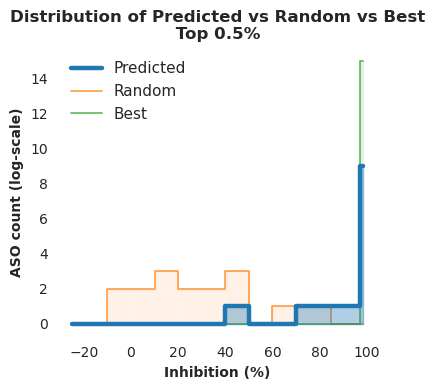

Model, best, random:  (91.0, 99.0, 35.0, 0.4)
Total correlation: P:0.533 S:0.481
Spearman dict:  {'A431': 0.42935267710231434, 'KARPAS-229': 0.28968786862661106, 'MM.1R': 0.48425461632353356, 'SK-MEL-28': 0.34034214636054316}
Score dict:  {'A431': 0.3577147134919205, 'KARPAS-229': 0.47418868735853653, 'MM.1R': 0.4246787600962474, 'SK-MEL-28': 0.5734606958175836}


In [306]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

metric = 'correct_log_inhibition2'

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
non_hepa_cancer['correct_log_inhibition'] = li / (non_hepa_cancer[VOLUME] / (non_hepa_cancer[VOLUME] + 10))
non_hepa_cancer['correct_log_inhibition2'] = li / (non_hepa_cancer[VOLUME] * 0.0000601 + 0.537)
non_hepa_cancer['correct_log_inhibition3'] = non_hepa_cancer['correct_log_inhibition2'] / (-0.032*  non_hepa_cancer[TREATMENT_PERIOD] + 2.36)


min_val = non_hepa_cancer[metric].min()
non_hepa_cancer[metric + 'ndcg'] = (
    non_hepa_cancer[metric] - min_val
)

selected_features = selected_features_tmp

# print(f"\nSelected {len(selected_features)} features for your model")
# if importance_scores:
#     best_feature = max([(f, s) for f, s in importance_scores.items() if f in selected_features], key=lambda x: x[1])
#     print(f"Most important selected feature: {best_feature[0]} (score: {best_feature[1]:.4f})")

print(f"\nSelected features: {selected_features[:10]}...")  # Show first 10

# === REST OF YOUR CODE WITH SELECTED FEATURES ===
cell_lines = ALL_CELL_LINES
genes = non_hepa_cancer[CANONICAL_GENE].unique()

seed = 42
# model = XGBRegressor(
#     n_estimators=1500,        # big + early_stopping
#     learning_rate=0.03,       # smaller step
#     max_depth=6,              # 4–8 is typical
#     min_child_weight=8,       # controls leaf complexity
#     subsample=0.8,            # row subsampling
#     colsample_bytree=0.7,     # feature subsampling
#     reg_lambda=2.0,           # L2
#     reg_alpha=0.5,            # L1
#     gamma=0.0,                # try 0–2 if overfitting
#     tree_method="hist",       # fast on CPU
#     n_jobs=-1,
#     random_state=42
# )

# model = XGBRanker(
#     objective="rank:ndcg",
#     ndcg_exp_gain=False,
#     lambdarank_pair_method="topk",
#     lambdarank_num_pair_per_sample=200,  # fewer pairs per sample
#     random_state=42,
#     n_jobs=-1,
# )

# model = XGBRanker(
#     objective='rank:ndcg',
#     ndcg_exp_gain=False,
#     lambdarank_pair_method="topk",
#     lambdarank_num_pair_per_sample=200,
#     tree_method="hist",       # faster, stable histogram splits
#     n_estimators=600,         # enough boosting rounds without being huge
#     learning_rate=0.1,        # default step size, safe
#     max_depth=6,              # moderate tree depth
#     min_child_weight=5,       # mild regularization
#     subsample=0.9,            # slight row sampling for robustness
#     colsample_bytree=0.9,     # slight feature sampling
#     reg_lambda=1.0,           # mild L2 regularization
#     random_state=seed,
#     n_jobs=-1
# )

model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk",
                  lambdarank_num_pair_per_sample=200,
                  seed=seed, n_jobs=-1
                  )


df_copy = non_hepa_cancer.copy()
gene = ""
top = []
spearman_dict = {}
score_dict = {}

for cell_line in cell_lines:
    if True:
        test_missing_cell_line = df_copy[(df_copy[CELL_LINE] == cell_line)]
        if len(test_missing_cell_line) < 100:
            continue

        train = df_copy[(df_copy[CELL_LINE] != cell_line)].copy()


        train, _ = train_test_split(train, test_size=0.2, random_state=seed) # TODO: uneeded, but comparable with previous

        train['group_key'] = train[CELL_LINE].astype(str)
        train = train.sort_values('group_key')
        group_train = train.groupby('group_key').size().tolist()

        # USE SELECTED FEATURES INSTEAD OF ALL FEATURES
        X = train[selected_features]  # CHANGED: using selected_features
        y = train[metric]

        model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
        # model.fit(X.to_numpy(), y.to_numpy())

        # CHANGED: using selected_features for predictions
        predicted_unseen = model.predict(test_missing_cell_line[selected_features].values)
        true_unseen = test_missing_cell_line[metric]

        predicted_seen = model.predict(filtered[selected_features].values)
        true_seen = filtered[metric]

        corr, _ = pearsonr(predicted_unseen, true_unseen)
        corrs, _ = spearmanr(predicted_unseen, true_unseen)
        corr2, _ = pearsonr(predicted_seen, true_seen)
        corrs2, _ = spearmanr(predicted_seen, true_seen)

        print(
            f"Length {cell_line:>10}, {gene:>10}:  {len(test_missing_cell_line):<6d} Pearson unseen: {corr:.3f} seen: {corr2:.3f}"
            f" Spearman unseen: {corrs:.3f} Spearman seen {corrs2:.3f}")

        # CHANGED: using selected_features
        score = model.score(test_missing_cell_line[selected_features].to_numpy(), test_missing_cell_line[metric].to_numpy())
        score_dict[cell_line] = score
        spearman_dict[cell_line] = corrs

        # CHANGED: using selected_features
        evaluated = evaluate_top(model, test_missing_cell_line, metric=metric, log_correction=log_correction,
                                 features=selected_features, plot=False, top_k=50)
        print("Model, best, random", evaluated)
        top.append(evaluated)
        y_true_corrected = test_missing_cell_line[metric + 'ndcg'].to_numpy()

        # ---- New metrics ----
        # NDCG@50
        ndcg50 = ndcg_score(y_true_corrected.reshape(1, -1), predicted_unseen.reshape(1, -1), k=200)
        # NDCG (all, just drop k)
        ndcg_all = ndcg_score(y_true_corrected.reshape(1, -1), predicted_unseen.reshape(1, -1))
        # Precision@50 (manual overlap of top-50 by truth vs pred)
        precisions = []
        values = [50, 100]
        for K in values:
            pred_top_idx = np.argpartition(predicted_unseen, -K)[-K:]
            true_top_idx = np.argpartition(y_true_corrected, -K)[-K:]
            precisions.append(len(set(pred_top_idx) & set(true_top_idx)) / K)

        print(f"NDCG@50: {ndcg50:.4f}, NDCG(all): {ndcg_all:.4f}, Precision: {values, precisions}")

print(top)
train, test = train_test_split(non_hepa_cancer, test_size=0.2, random_state=seed)
train['group_key'] = train[CELL_LINE].astype(str)
train = train.sort_values('group_key')
group_train = train.groupby('group_key').size().tolist()

# CHANGED: using selected_features
X = train[selected_features]
y = train[metric]

model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
# model.fit(X.to_numpy(), y.to_numpy())

# CHANGED: using selected_features
evaluated = evaluate_top(model, test, metric=metric, log_correction=log_correction,
                         features=selected_features,
                         plot=True)
print("Model, best, random: ", evaluated)

# CHANGED: using selected_features
predicted = model.predict(non_hepa_cancer[selected_features].values)
true = non_hepa_cancer[metric]

corrp, _ = pearsonr(predicted, true)
corrs, _ = spearmanr(predicted, true)

print(f"Total correlation: P:{corrp:.3f} S:{corrs:.3f}")
print("Spearman dict: ", spearman_dict)
print("Score dict: ", score_dict)

In [ ]:
def evaluate_top(model, test, metric, features, log_correction, top_k=None, plot=False):
    # --- helpers ---
    def to_inhibition(arr, df):
        if metric == INHIBITION:
            return arr.astype(float)
        elif metric == 'log_inhibition':
            return log_inhibition_to_regular(arr, log_correction).astype(float)
        elif metric == 'correct_log_inhibition':
            return log_inhibition_to_regular(arr * correction(df), log_correction).astype(float)
        elif metric == 'correct_log_inhibition2':
            return log_inhibition_to_regular(arr * correction2(df), log_correction).astype(float)
        else:
            raise ValueError(f"Unknown metric {metric}")

    def ndcg_at_k(y_true, y_pred, k, exp_gain=False):
        k = int(min(max(1, k), len(y_true)))
        order = np.argsort(-y_pred)
        yk = y_true[order][:k]
        ik = np.sort(y_true)[::-1][:k]
        if exp_gain:
            gains = (2.0 ** yk - 1.0)
            gains_i = (2.0 ** ik - 1.0)
        else:
            gains = yk
            gains_i = ik
        disc = 1.0 / np.log2(np.arange(2, k + 2))
        dcg = float(np.sum(gains * disc))
        idcg = float(np.sum(gains_i * disc))
        return 0.0 if idcg <= 0 else dcg / idcg

    # --- data ---
    X = test[features].to_numpy()
    y_pred = model.predict(X)
    y_raw = test[metric].to_numpy()
    y = to_inhibition(y_raw, test)

    # detect cell-line column (optional)
    if 'CELL_LINE' in test.columns:
        cell_col = 'CELL_LINE'
    elif 'cell_line' in test.columns:
        cell_col = 'cell_line'
    else:
        cell_col = None

    # choose k (per group if grouping; else global)
    if top_k is None:
        percentile = 0.5
        if cell_col:
            ks = []
            for _, idx in test.groupby(cell_col).groups.items():
                thr = get_threshold_for_percentile(percentile, y_pred[idx])
                ks.append(max(1, int(np.sum(y_pred[idx] > thr))))
        else:
            thr = get_threshold_for_percentile(percentile, y_pred)
            ks = [max(1, int(np.sum(y_pred > thr)))]
    else:
        ks = [int(top_k)]

    # compute NDCG (macro over groups if present)
    rng = np.random.default_rng(42)
    ndcgs, ndcgs_rand = [], []

    if cell_col:
        for g, idx in test.groupby(cell_col).groups.items():
            yg = y[idx].astype(float)
            # shift to non-negative for NDCG
            yg = yg - yg.min()
            pg = y_pred[idx].astype(float)
            k = ks[0] if len(ks) == 1 else ks.pop(0)
            ndcgs.append(ndcg_at_k(yg, pg, k, exp_gain=False))
            ndcgs_rand.append(ndcg_at_k(yg, rng.random(len(yg)), k, exp_gain=False))
        ndcg_model = float(np.mean(ndcgs)) if ndcgs else 0.0
        ndcg_random = float(np.mean(ndcgs_rand)) if ndcgs_rand else 0.0
    else:
        yg = y.astype(float) - float(np.min(y))
        k = ks[0]
        ndcg_model = ndcg_at_k(yg, y_pred.astype(float), k, exp_gain=False)
        ndcg_random = ndcg_at_k(yg, rng.random(len(yg)), k, exp_gain=False)

    ndcg_best = 1.0  # by definition

    # optional plot: simple bars
    if plot:
        import matplotlib.pyplot as plt
        labels = ['Model NDCG@k', 'Best (1.0)', 'Random']
        vals = [ndcg_model, 1.0, ndcg_random]
        plt.figure(figsize=(4, 3))
        plt.bar(labels, vals)
        plt.ylim(0, 1.05)
        plt.title('NDCG@k')
        plt.tight_layout()
        plt.show()

    return ndcg_model, ndcg_best, ndcg_random

In [ ]:
for feature in sorted(importance_scores.items(), key=lambda x: x[1], reverse=True):
    print(feature)

In [ ]:
# Add this after your existing code

# Feature selection using Random Forest importance
print("\n=== FEATURE SELECTION ===")
rf_selector = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_selector.fit(non_hepa_cancer[features].values, non_hepa_cancer[metric].values)

# Get feature importances and select top features
importances = rf_selector.feature_importances_
feature_importance_pairs = list(zip(features, importances))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Select top 30 features (adjust this number as needed)
n_top_features = 30
selected_features = [feat for feat, imp in feature_importance_pairs[:n_top_features]]

print(f"Selected {len(selected_features)} most important features:")
for i, (feat, imp) in enumerate(feature_importance_pairs[:10]):  # Show top 10
    print(f"{i + 1:2d}. {feat:<30} {imp:.4f}")

print(f"\nSelected features: {selected_features}")

In [ ]:
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt

corrs, pval = spearmanr(predicted, true)

# If pval is exactly 0, replace with smallest positive float
if pval == 0.0:
    pval_display = np.nextafter(0, 1)
else:
    pval_display = pval

fig, ax = plt.subplots(figsize=(4, 4), facecolor="none")
fig.patch.set_alpha(0.0)
ax.set_facecolor("none")

ax.scatter(predicted, true, alpha=0.2)

# Best-fit line (linear regression)
coef = np.polyfit(predicted, true, 1)
poly1d_fn = np.poly1d(coef)
x_line = np.linspace(np.min(predicted), np.max(predicted), 200)
ax.plot(x_line, poly1d_fn(x_line), 'r--', lw=1.5)

# Bold labels
ax.set_xlabel("Predicted relative order", fontweight="bold")
ax.set_ylabel("Actual log-inhibition", fontweight="bold")

# Correlation text with box
ax.text(0.05, 0.95,
        f"Spearman ρ = {corrs:.3f}\np < {pval_display:.2e}",
        transform=ax.transAxes,
        va="top", ha="left", fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                  edgecolor="none", alpha=0.6))

ax.legend(frameon=False, fontsize=10)

fig.tight_layout()
plt.show()


In [ ]:
filtered_original = filtered

print(filtered_original[CELL_LINE].unique())
# only_cancer = filtered_original
non_hepa_cancer = filtered_original[filtered_original[CELL_LINE] != 'A-431']

# only_cancer = filtered[(filtered_original[CELL_LINE] == 'HepG2')
#                        | (filtered_original[CELL_LINE] == 'HepaRG')
#                           ]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from scripts.Models.model_helpers import evaluate_top
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRanker
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

cell_lines = non_hepa_cancer[CELL_LINE].unique()
genes = non_hepa_cancer[CANONICAL_GENE].unique()

seed = 42
# model = RandomForestRegressor(
#     n_estimators=600,      # more trees → stabler
#     max_depth=8,          # limit depth
#     min_samples_leaf=15,   # larger leaves
#     min_samples_split=20,  # stronger split guard
#     max_features=0.3,      # more randomness per split
#     bootstrap=True,
#     max_samples=0.6,       # subsample rows (bagging)
#     oob_score=True,        # quick gen-error check
#     n_jobs=-1,
#     random_state=seed
# )
# model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed, n_jobs=-1)
model = LinearRegression()

metric = 'correct_log_inhibition'

gene = ''
top = []
for cell_line in cell_lines:
    # for gene in genes:
    if True:
        # missing_cell_line = only_cancer[(only_cancer[CELL_LINE] == cell_line) & (only_cancer[CANONICAL_GENE] == gene)]
        test_missing_cell_line = non_hepa_cancer[(non_hepa_cancer[CELL_LINE] == cell_line)]
        if len(test_missing_cell_line) < 100:
            continue

        # filtered = only_cancer[(only_cancer[CELL_LINE] != cell_line) & (only_cancer[CELL_LINE] != gene)]
        filtered = non_hepa_cancer[(non_hepa_cancer[CELL_LINE] != cell_line)]
        train, test = train_test_split(filtered, test_size=0.2, random_state=seed)
        train['group_key'] = train[CELL_LINE].astype(str)
        # train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
        train = train.sort_values('group_key')
        group_train = train.groupby('group_key').size().tolist()

        # metric = 'log_inhibition'
        # metric = INHIBITION

        X = train[features]
        # y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
        y = train[metric]

        # model = RandomForestRegressor(
        #     n_estimators=600,      # more trees → stabler
        #     max_depth=8,          # limit depth
        #     min_samples_leaf=15,   # larger leaves
        #     min_samples_split=20,  # stronger split guard
        #     max_features=0.3,      # more randomness per split
        #     bootstrap=True,
        #     max_samples=0.6,       # subsample rows (bagging)
        #     oob_score=True,        # quick gen-error check
        #     n_jobs=-1,
        #     random_state=seed
        # )
        # model = XGBRanker(objective='rank:pairwise')
        # model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
        model.fit(X.to_numpy(), y.to_numpy())

        predicted_unseen = model.predict(test_missing_cell_line[features].values)
        true_unseen = test_missing_cell_line[metric]

        predicted_seen = model.predict(filtered[features].values)
        true_seen = filtered[metric]

        top.append(evaluate_top(model, test_missing_cell_line, metric=metric, log_correction=log_correction, top_k=50,
                                features=features))

        corr, _ = pearsonr(predicted_unseen, true_unseen)
        corrs, _ = spearmanr(predicted_unseen, true_unseen)
        corr2, _ = pearsonr(predicted_seen, true_seen)
        corrs2, _ = spearmanr(predicted_seen, true_seen)

        print(
            f"Length {cell_line:>10}, {gene:>10}:  {len(test_missing_cell_line):<6d} Pearson unseen: {corr:.3f} seen: {corr2:.3f}"
            f" Spearman unseen: {corrs:.3f} Spearman seen {corrs2:.3f}")

        # plt.scatter(predicted_unseen, true_unseen)
        # plt.show()

print(top)
train, test = train_test_split(non_hepa_cancer, test_size=0.2, random_state=seed)
train['group_key'] = train[CELL_LINE].astype(str)
train = train.sort_values('group_key')
group_train = train.groupby('group_key').size().tolist()
metric = 'correct_log_inhibition'
X = train[features]
y = train[metric]
# model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
model.fit(X.to_numpy(), y.to_numpy())

predicted = model.predict(non_hepa_cancer[features].values)
true = non_hepa_cancer[metric]

corrp, _ = pearsonr(predicted, true)
corrs, _ = spearmanr(predicted, true)

print(f"Total correlation: P:{corrp:.3f} S:{corrs:.3f}")


In [ ]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

train_filtered = train.copy()
test_filtered = test.copy()

# train_filtered = train.nlargest(200, metric)
# test_filtered = test.nlargest(200, metric)

train_pred = model.predict(train_filtered[features].to_numpy())
test_pred = model.predict(test_filtered[features].to_numpy())

y_test = test_filtered[metric].to_numpy()
y_train = train_filtered[metric].to_numpy()

cell_lines = filtered[CELL_LINE].unique()
# for cell_line in cell_lines:
for cell_line in cell_lines:
    cell_line_mask = filtered[CELL_LINE] == cell_line
    print(f"cell-line:{cell_line}, length:{cell_line_mask.sum()} ", cell_line)
    print(metric)

    for gene in filtered[cell_line_mask][CANONICAL_GENE].unique():
        hepa_mask = cell_line_mask & (filtered[CANONICAL_GENE] == gene)
        print(f"gene-{gene} length: {hepa_mask.sum()}")
        # for f in ['sense_exon', 'sense_intron', 'sense_utr']:
        for f in ['NA']:
            # hep_pred = filtered[hepa_mask][f].to_numpy()
            # print(f"{f}: {filtered[hepa_mask][f].sum()} / {hepa_mask.sum()}")
            hep_pred = model.predict(filtered[hepa_mask][features].to_numpy())
            hepa_truth = filtered[hepa_mask][metric]
            p_hepa, pp_value = pearsonr(hepa_truth, hep_pred)
            s_hepa, sp_value = spearmanr(hepa_truth, hep_pred)
            print(f"P:{p_hepa:.2}, p-value: {pp_value:.2}")
            print(f"S:{s_hepa:.2} , p-value: {sp_value:.2}")

for feature in features:
    # EXAMPLE = 'GGCATATGCAGATAATGTTC'

    # malat_mask = filtered[CELL_LINE] == 'U251'

    # malat_mask = filtered[CANONICAL_GENE] == "HSD17B13"
    malat_mask = filtered[CANONICAL_GENE] == "MALAT1"
    # example_mask = (filtered[CANONICAL_GENE] == "MALAT1") & (filtered[SEQUENCE] == EXAMPLE)
    malat_pred = model.predict(filtered[malat_mask][features].to_numpy())
    print(metric)
    malat_truth = filtered[malat_mask][metric]
    p_hepa, pp_value = pearsonr(malat_truth, filtered[malat_mask][feature])
    s_hepa, sp_value = spearmanr(malat_truth, filtered[malat_mask][feature])

    plt.scatter(filtered[malat_mask][feature], malat_truth)
    # example_df = filtered.loc[example_mask, :].copy()
    # plt.scatter(example_df[feature], malat_truth[example_mask], color='orange')
    plt.scatter(filtered[malat_mask][feature], malat_truth, color='blue', alpha=0.05)
    plt.xlabel(feature)
    plt.ylabel(metric)
    print("Feature: ", feature)
    print(f"P:{p_hepa:.2} p-value {pp_value:.2}")
    print(f"S:{s_hepa:.2} p-value {sp_value:.2}")
    plt.show()

p_hepa, _ = pearsonr(malat_truth, malat_pred)
s_hepa, _ = spearmanr(malat_truth, malat_pred)
print("P: ", p_hepa)
print("S: ", s_hepa)

p_train, _ = pearsonr(y_train, train_pred)
s_train, _ = spearmanr(y_train, train_pred)
p_test, p_value_ptest = pearsonr(y_test, test_pred)
s_test, p_value_stest = spearmanr(y_test, test_pred)

print("PTRAIN: ", p_train)
print("PTEST: ", p_test)
print("STRAIN: ", s_train)
print("STEST: ", s_test)
print("PvaluePtest: ", p_value_ptest)
print("PValueStest: ", p_value_stest)

# scatter plot
# plt.scatter(test_pred, y_test, alpha=0.2)
plt.scatter(malat_pred, malat_truth, alpha=0.2)

# least‑squares regression line
# slope, intercept = np.polyfit(test_pred, y_test, 1)
# x = np.linspace(test_pred.min(), test_pred.max(), 100)
# plt.plot(x, slope * x + intercept, color='red')

# labels and stats
plt.xlabel('Predicted ranking')
plt.ylabel(metric)
txt = (
    f"Train Pearson:  {p_train:.2f}\n"
    f"Train Spearman: {s_train:.2f}\n"
    f"Test Pearson:   {p_test:.2f}\n"
    f"Test Spearman:  {s_test:.2f}"
)
plt.text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [ ]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [ ]:
from scripts.Models.model_helpers import log_inhibition_to_regular


def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


# def correction(df):
#     return (df['log_volume'])

# def correction(df):
#     return (df[VOLUME]) / df[VOLUME]

def correction(df):
    return df[VOLUME] / (df[VOLUME] + 10)


for percentile in [1, 5, 10, 50]:
    threshold = get_threshold_for_percentile(percentile, log_inhibition_to_regular(filtered['log_inhibition']))
    # print(correction(filtered))
    # print(log_inhibition_to_regular(filtered['log_inhibition']))
    print(f"Threshold for top_{percentile}: {threshold}")

In [ ]:
evaluate_top(model, train, test)

In [ ]:
MALAT_scores = model.predict(filtered[filtered[CANONICAL_GENE] == 'MALAT1'][features])
MALAT_scores.sort()
print(MALAT_scores)
get_threshold_for_percentile(1, MALAT_scores)

In [ ]:
# ---------------------------------------------------------------------------
# 5-fold “stable” permutation-importance for an XGBRanker (rank:pairwise)
# – one query = all rows that share the same CELL_LINE ----------------------
# ---------------------------------------------------------------------------

from xgboost import XGBRanker
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from scipy import stats
import numpy as np
import pandas as pd

metric = "correct_log_inhibition"  # target column
groups = filtered[CELL_LINE]  # one “qid” per row
gkf = GroupKFold(n_splits=6)


def spearman_scorer(est, X, y):  # (estimator, X, y) signature
    return stats.spearmanr(y, est.predict(X)).correlation ** 2


all_imps = []

for tr_idx, te_idx in gkf.split(filtered, filtered[metric], groups):
    # ---- build train / test sets -----------------------------------------
    train_df = filtered.iloc[tr_idx].sort_values(CELL_LINE)  # keep queries contiguous
    test_df = filtered.iloc[te_idx]

    X_tr, y_tr = train_df[features], train_df[metric]
    X_te, y_te = test_df[features], test_df[metric]

    group_train = train_df.groupby(CELL_LINE).size().tolist()  # sizes per query

    # ---- fit a fresh ranker on this fold ---------------------------------
    ranker = XGBRanker(objective="rank:pairwise", random_state=42)
    ranker.fit(X_tr.to_numpy(), y_tr.to_numpy(), group=group_train)

    # ---- permutation importance on the hold-out --------------------------
    r = permutation_importance(
        ranker, X_te.to_numpy(), y_te.to_numpy(),
        n_repeats=30, scoring=spearman_scorer,
        random_state=42, n_jobs=1
    )
    all_imps.append(r.importances_mean)

# --------------------------------------------------------------------------
# aggregate across folds
imp_mat = np.vstack(all_imps)  # (folds × features)
imp_df = pd.DataFrame(
    imp_mat.T,
    index=features,
    columns=[f"fold_{i + 1}" for i in range(imp_mat.shape[0])]
)

summary = (imp_df
           .agg(["mean", "std"], axis=1)
           .rename(columns={"mean": "mean_imp", "std": "std_imp"})
           .sort_values("mean_imp", ascending=False))


In [ ]:
print(summary.head(15))


In [ ]:

GFP_IN_YEAST = (
    'ATGGTtAGtAAaGGaGAaGAGTTgTTCACaGGaGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGGTGCTGGGGCAggtacCCCTAAAGATCCAGCCAAACCTCCGGCCAcGGCACAAGTTGTGGGATGGCCACCGGTGAGATCATACCGGAAGAACGTGATGGTTTCCTGCCAAAAATCAAGCGGTGGCCCGGAGGCGGCGGCGTTCGTGAAGTAA'
    .upper())
GFP_IN_HUMAN = (
    "atggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagaagcttagccatggcttcccgccggaggtggaggagcaggatgatggcacgctgcccatgtcttgtgcccaggagagcgggatggaccgtcaccctgcagcctgtgcttctgctaggatcaatgtgaagcgacctgccgccacaaagaaggctggacaggctaagaagaagaaatgaggatcccgcgcgcgcatatgttaattaaccaactgcatggggatccacgcgttaagtcgacaatcaacctctggattacaaaatttgtgaaagattgactggtattcttaactatgttgctccttttacgctatgtggatacgctgctttaatgcctttgtatcatgctattgcttcccgtatggctttcattttctcctccttgtataaatcctggttgctgtctctttatgaggagttgtggcccgttgtcaggcaacgtggcgtggtgtgcactgtgtttgctgacgcaacccccactggttggggcattgccaccacctgtcagctcctttccgggactttcgctttccccctccctattgccacggcggaactcatcgccgcctgccttgcccgctgctggacaggggctcggctgttgggcactgacaattccgtggtgttgtcggggaaatcatcgtcctttccttggctgctcgcctgtgttgccacctggattctgcgcgggacgtccttctgctacgtcccttcggccctcaatccagcggaccttccttcccgcggcctgctgccggctctgcggcctcttccgcgtcttcgccttcgccctcagacgagtcggatctccctttgggccgcctccccgcgtcgactttaagaccaatgacttacaaggcagctgtagatcttagccactttttaaaagaaaaggggggactggaagggctaattcactcccaacgaagacaagatctgctttttgcttgtactgggtctctctggttagaccagatctgagcctgggagctctctggctaactagggaacccactgcttaagcctcaataaagcttgccttgagtgcttcaagtagtgtgtgcccgtctgttgtgtgactctggtaactagagatccctcagacccttttagtcagtgtggaaaatctctagcagtacgtatagtagttcatgtcatcttattattcagtatttataacttgcaaagaaatgaatatcagagagtgagagg".upper()
)
# GFP + Degron x <= 842
# NLS 843 <= x<= 893
# 3UTR 1615 <= x <= 1848


In [ ]:
from scripts.data_genertion.data_handling import get_unique_human_genes

from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=['MALAT1'])
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

MALAT = gene_to_data['MALAT1'].full_mrna

In [ ]:
from asodesigner.util import get_antisense
import pandas as pd

GFP_YEAST_END = len(GFP_IN_YEAST) - 3
GFP_HUMAN_END = 891  # TGA stop codon in NLS
malat_info = gene_to_data['MALAT1']
MALAT_END = malat_info.exon_indices[-1][1] - malat_info.cds_start


def get_init_df(target_mrna, end):
    candidates = []
    sense_starts = []
    sense_lengths = []
    sense_starts_from_end = []

    for i in range(0, len(target_mrna) - 19):
        target = target_mrna[i: i + 20]
        candidates.append(get_antisense(str(target)))
        sense_starts.append(i)
        sense_lengths.append(20)
        sense_starts_from_end.append(end - i)
    df = pd.DataFrame(
        {SEQUENCE: candidates, SENSE_START: sense_starts,
         SENSE_LENGTH: sense_lengths, "sense_start_from_end": sense_starts_from_end})
    return df


SEQUENCES = [GFP_IN_YEAST, GFP_IN_HUMAN, MALAT]
df_yeast = get_init_df(GFP_IN_YEAST, GFP_YEAST_END)
df_human = get_init_df(GFP_IN_HUMAN, GFP_HUMAN_END)
df_malat = get_init_df(MALAT, MALAT_END)

In [ ]:
df_yeast[CANONICAL_GENE] = 'YEAST_GFP'
df_human[CANONICAL_GENE] = 'HUMAN_GFP'
df_malat[CANONICAL_GENE] = 'MALAT1'
dataframes = [df_yeast, df_human, df_malat]

In [ ]:
for df in dataframes:
    df[CELL_LINE_ORGANISM] = 'human'
    df[INHIBITION] = 0  # Just for the function, not important

In [ ]:
df_malat = get_populated_df_with_structure_features(df_malat, ['MALAT1'], gene_to_data)
dataframes[2] = df_malat
df_malat

In [ ]:
df_yeast['sense_exon'] = 1
df_human['sense_exon'] = 1
df_yeast['sense_intron'] = 0
df_human['sense_intron'] = 0
df_yeast['sense_utr'] = 0
df_human['sense_utr'] = [1 if sense_start > 842 else 0 for sense_start in df_human[SENSE_START]]

In [ ]:
from scripts.data_genertion.data_handling import populate_features

for i, df in enumerate(dataframes):
    df[TREATMENT_PERIOD] = 24  # keep constant for all
    df[VOLUME] = 1000  # keep constant for all
    df['log_volume'] = np.log(df[VOLUME])
    df['normalized_start'] = df[SENSE_START] / len(SEQUENCES[i])
    df['normalized_sense_start_from_end'] = df['sense_start_from_end'] / len(SEQUENCES[i])
    easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                        'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                        'at_rich_region_score', 'poly_pyrimidine_stretch']
    populate_features(df, easy_to_populate)


In [ ]:
%reload_ext autoreload
%autoreload 2

from asodesigner.process_utils import LocusInfo
from scripts.data_genertion.data_handling import get_populate_fold

genes_u = ['YEAST_GFP', 'HUMAN_GFP', 'MALAT1']
gene_to_data = {'YEAST_GFP': LocusInfo(), 'HUMAN_GFP': LocusInfo(), 'MALAT1': LocusInfo()}
gene_to_data['YEAST_GFP'].full_mrna = GFP_IN_YEAST
gene_to_data['HUMAN_GFP'].full_mrna = GFP_IN_HUMAN
gene_to_data['MALAT1'].full_mrna = MALAT


In [ ]:
for i in range(len(dataframes)):
    fold_variants = [(40, 15)]
    dataframes[i] = get_populate_fold(dataframes[i], genes_u, gene_to_data, fold_variants=fold_variants)


In [ ]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

for df in dataframes:
    df.loc[:, 'exp_ps_hybr'] = [
        get_exp_psrna_hybridization(antisense.replace('T', 'U'), temp=37) for
        antisense in df[SEQUENCE]]
    print(df.columns)

In [ ]:
scores_per_gfp = []
for df in dataframes:
    scores_per_gfp.append(model.predict(df[features]))

In [ ]:
index = 0
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('yeast_gfp_asos.csv', index=False)

In [ ]:
index = 1
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('human_gfp_asos.csv', index=False)


In [ ]:
index = 2
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('malat_asos.csv', index=False)

In [ ]:
index = 0
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])

previous_experiment = [
    'CCTAGGGACAACGGTCATCG',
    'AAACACGAAATTGGCAGGGG',
    'CAAGACATGGGCAGCGTGCC',
    'GGACACGCTGAACTTGTGGC',
    'TGAAGAAGATGGTGCGCTCC',
    'GCGTGCCATCATCCTGCTCC',
    'CGGGCACACACTACTTGAAG',
    'TGATCGCGCTTCTCGTTGGG'
]
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)
previous_asos = df_with_scores[df_with_scores[SEQUENCE].isin(previous_experiment)]

previous_asos[[SEQUENCE, 'relative_score', 'sense_start']]

In [ ]:
chinese_aso = df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA']
chinese_score = chinese_aso['score'].iloc[0]
print(chinese_aso[[SEQUENCE, 'relative_score', 'sense_start']])

In [ ]:
plt.hist(df_with_scores['score'], bins=40, alpha=0.5, label='scores', log=True)
plt.hist(chinese_aso['score'], bins=40, alpha=0.5, color='red', label='scores', log=True)

plt.show()

In [ ]:
index = 2
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

EXAMPLE = 'GGCATATGCAGATAATGTTC'

plt.hist(df_with_scores['score'], bins=20, alpha=0.5, label='scores', log=True)
plt.hist(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'], bins=20, alpha=0.5, color='red', label='scores',
         log=True)

plt.show()
score = df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'].iloc[0]
len(df_with_scores[df_with_scores['score'] > score]) / len(df_with_scores)
print(score)
print(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['relative_score'])

In [ ]:
k = 10  # how many bot rows
idx = np.argsort(scores)[:k]
print(df_with_scores.iloc[idx])
# print(df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA'])

In [ ]:
index = 2
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

metric = 'correct_log_inhibition'


def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")


# for gene in genes_u:
# print("gene, ", gene)
feature = 'gc_content'
current_df = df_with_scores
current_df = df_with_scores[df_with_scores[CANONICAL_GENE] == 'MALAT1']
plt.scatter(current_df[feature], current_df['score'], alpha=0.2)
plt.scatter(current_df[current_df[SEQUENCE] == EXAMPLE][feature], current_df[current_df[SEQUENCE] == EXAMPLE]['score'])
plt.xlabel('Place in gene')
plt.ylabel(f'score')
plt.show()

print_correlations(current_df, feature, 'score')
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', metric)
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', 'score')

In [ ]:
for feature in features:
    plt.scatter(current_df[feature], current_df['score'])
    # plt.scatter(current_df[feature], current_df['log_inhibition'])
    special_aso = current_df[current_df[SEQUENCE] == 'GGCATATGCAGATAATGTTC']
    plt.scatter(special_aso[feature], special_aso['score'])
    plt.xlabel(f'Feature: {feature}')
    plt.ylabel(f'Score: {score}')
    plt.show()

In [ ]:
from fuzzysearch import find_near_matches

m = find_near_matches('TCTGCATCTAGGCCATCATA', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)
m = find_near_matches('GATGGACATTGCCTCTTCAT', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)
m = find_near_matches('CTCCAGTCGTTTCACAATGC', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)

In [ ]:
# Generate scrambled
import random

GFP_BEST = dataframes[0][:30][[SEQUENCE]]
scrambled_df = GFP_BEST.copy()


def shuffle_seq(seq, seed=45):
    rng = random.Random(seed)
    lst = list(seq)
    rng.shuffle(lst)
    return ''.join(lst)


scrambled_df[SEQUENCE] = [shuffle_seq('CTGCTTGTCGGCCATGATAT') for seq in scrambled_df[SEQUENCE]]

easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                    'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                    'at_rich_region_score', 'poly_pyrimidine_stretch']
populate_features(scrambled_df, easy_to_populate)


In [ ]:
# Check for on-target GFP
for seq in scrambled_df[SEQUENCE]:
    m = find_near_matches(seq, GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=3)
    if m:
        print(seq)

In [ ]:
scrambled_df[0:1]

In [ ]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

a = get_exp_psrna_hybridization('ACGATGGTCCTTCTTGTGAC'.replace('T', 'U'), temp=37)
scrambled_df['exp_ps_hybr'] = a

In [ ]:
scrambled_df[0:1]